Тренировка нейросети по детекции бургер-меню

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import cv2
import time
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.ops.boxes import nms
from google.colab import drive
drive.mount ('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/Krilaria/Burger_Dataset.git

Cloning into 'Burger_Dataset'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 234 (delta 5), reused 64 (delta 1), pack-reused 160
Receiving objects: 100% (234/234), 17.71 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [3]:
df_train = pd.read_csv("/content/Burger_Dataset/Train_140.csv", 
                       names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class']) 
df_val = pd.read_csv('/content/Burger_Dataset/Val_150.csv', 
                    names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class'])

In [4]:
df_train['bbox'] = df_train[['xmin', 'ymin', 'xmax', 'ymax']].apply(list, axis=1)
df_val['bbox'] = df_val[['xmin', 'ymin', 'xmax', 'ymax']].apply(list, axis=1)

df_train['class'] = df_train['class'].map({'burger-menu': 1})
df_val['class'] = df_val['class'].map({'burger-menu': 1})

df_train = df_train.drop(columns=['xmin', 'ymin', 'xmax', 'ymax']).groupby('filename', as_index=False).agg(list)
df_val = df_val.drop(columns=['xmin', 'ymin', 'xmax', 'ymax']).groupby('filename', as_index=False).agg(list)

print(f'Число изображений в тренировочной выборке: {df_train["filename"].nunique()}')
print(f'Число изображений в валидационной выборке: {df_val["filename"].nunique()}')

df_train.head(2)

Число изображений в тренировочной выборке: 140
Число изображений в валидационной выборке: 10


,filename,class,bbox
0,001.jpg,[1],"[[545, 140, 585, 170]]"
1,002.jpg,[1],"[[555, 137, 590, 170]]"


In [7]:
class MyDataset(Dataset):
  
    def __init__(self, dataframe, img_path):
        
        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df.loc[index,'filename']
        boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

In [8]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
batch_size = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(df_train, '/content/Burger_Dataset/pics')
val_dataset = MyDataset(df_val, '/content/Burger_Dataset/pics')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.4MB/s]


In [11]:
def train(train_dataloader): 
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 15 == 0:
            print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [16]:
num_epoch = 40

train_losses = []
val_losses = []
try:
    start1 = time.time()
    for epoch in range(num_epoch):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch+1} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch+1}-ю эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    endend = time.time()
    print(f"Всего потрачено {round((endend - start1) / 60, 1)} минут")
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация #0 loss: 0.11134662479162216
	Итерация #15 loss: 0.08920129388570786
Эпоха #1 train_loss: 0.021753155466701302, val_loss: 0.0237124040722847
Потрачено 0.8 минут на 1-ю эпоху
	Итерация #0 loss: 0.13123202323913574
	Итерация #15 loss: 0.23468923568725586
Эпоха #2 train_loss: 0.018958125981901372, val_loss: 0.016943564265966417
Потрачено 0.8 минут на 2-ю эпоху
	Итерация #0 loss: 0.04738519713282585
	Итерация #15 loss: 0.083576500415802
Эпоха #3 train_loss: 0.016401296907237597, val_loss: 0.01876881942152977
Потрачено 0.8 минут на 3-ю эпоху
	Итерация #0 loss: 0.044854067265987396
	Итерация #15 loss: 0.28152573108673096
Эпоха #4 train_loss: 0.01438069673521178, val_loss: 0.016986504197120667
Потрачено 0.8 минут на 4-ю эпоху
	Итерация #0 loss: 0.06187811493873596
	Итерация #15 loss: 0.19952179491519928
Эпоха #5 train_loss: 0.014449504709669521, val_loss: 0.014322438836097717
Потрачено 0.8 минут на 5-ю эпоху
	Итерация #0 loss: 0.042878396809101105
	Итерация #15 loss: 0.0560566969215

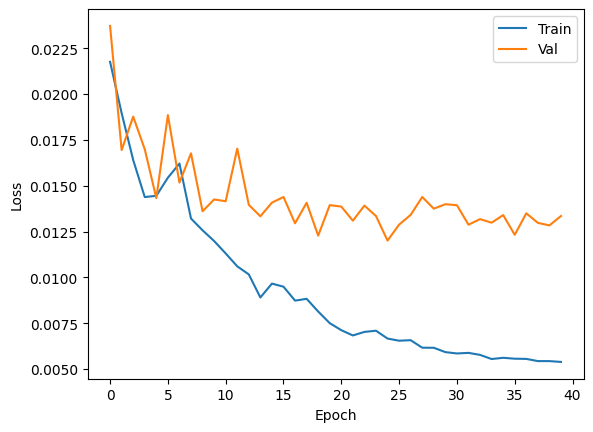

In [17]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [18]:
def draw_predict(df_index, iou_threshold=0.1, threshold=0.8, scale_percent=80): # 0.1  порог IoU для NMS    0.8 порог для отбора предсказаний
    model.eval() # режим оценки
    img = cv2.imread(os.path.join('/content/Burger_Dataset/pics', df_val.loc[df_index, 'filename'])) # загрузка картинки (указание пути)
    img_ = img / 255. # normalization
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device) # img to tensor, изменяется размерность и приводится к float
    predict = model(img_) # получение предсказаний
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy() #
    for i, box in enumerate(predict[0]['boxes'][ind]): #
        if predict[0]['scores'][i] > threshold: #++
            cv2.rectangle(img, 
                    (int(box[0]), int(box[1])), 
                    (int(box[2]), int(box[3])), 
                    (0, 0, 255), 4)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)   
    img = cv2.resize(img, dim)
    cv2_imshow(img)

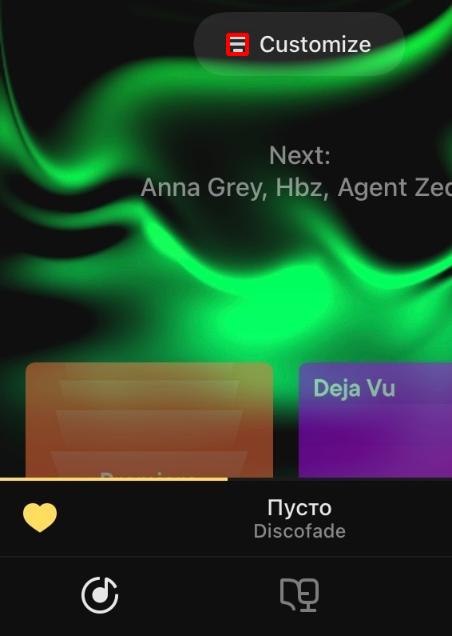

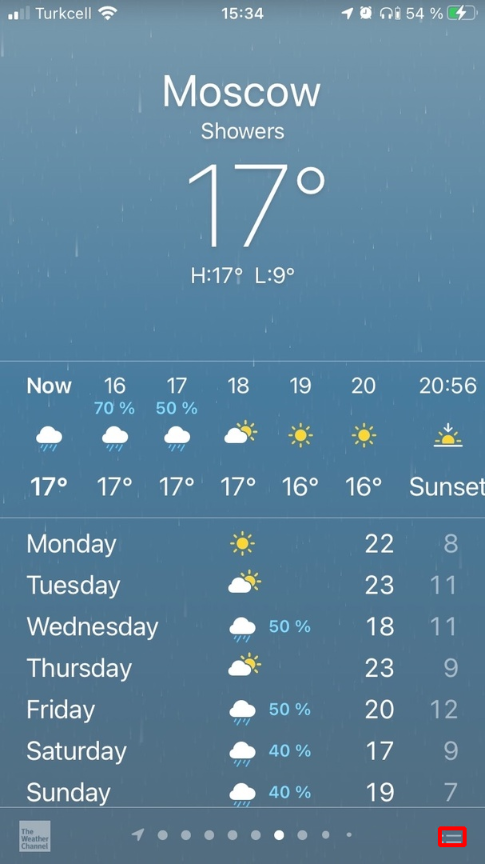

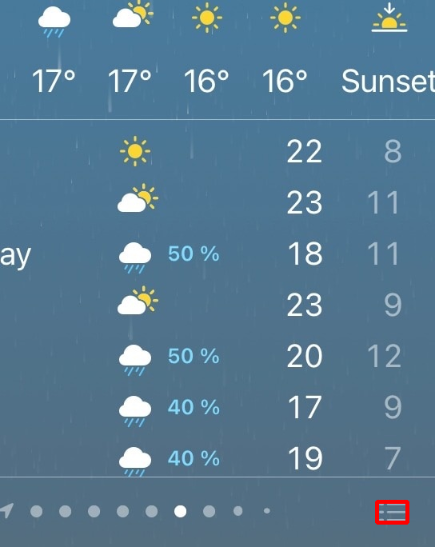

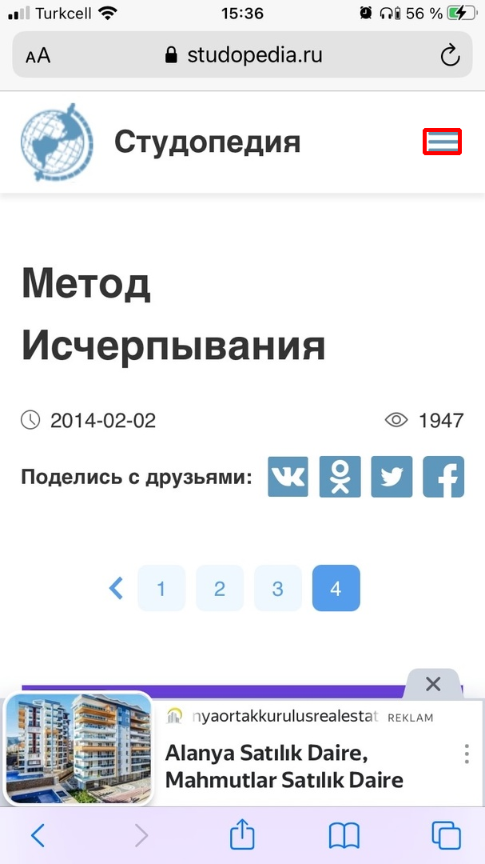

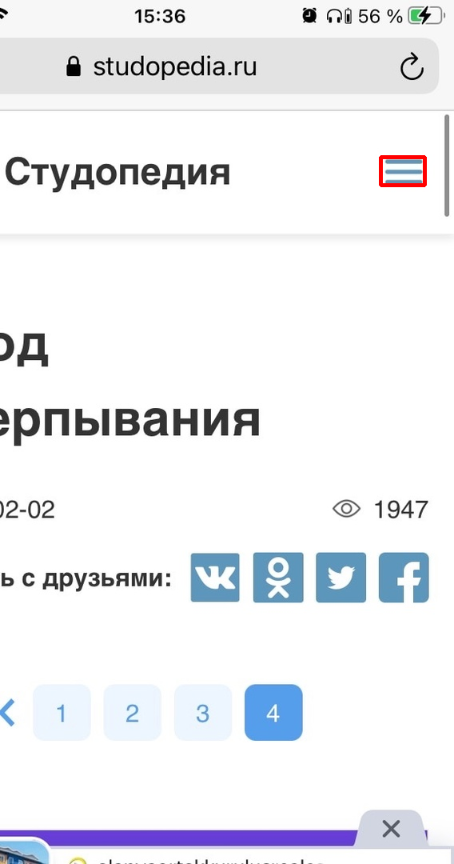

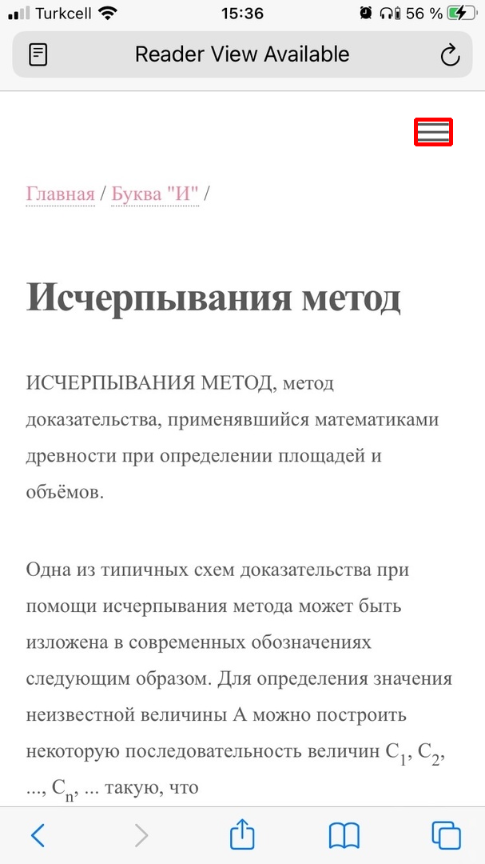

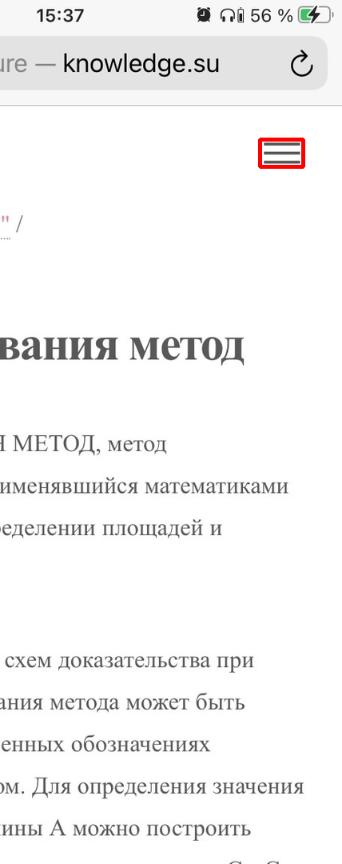

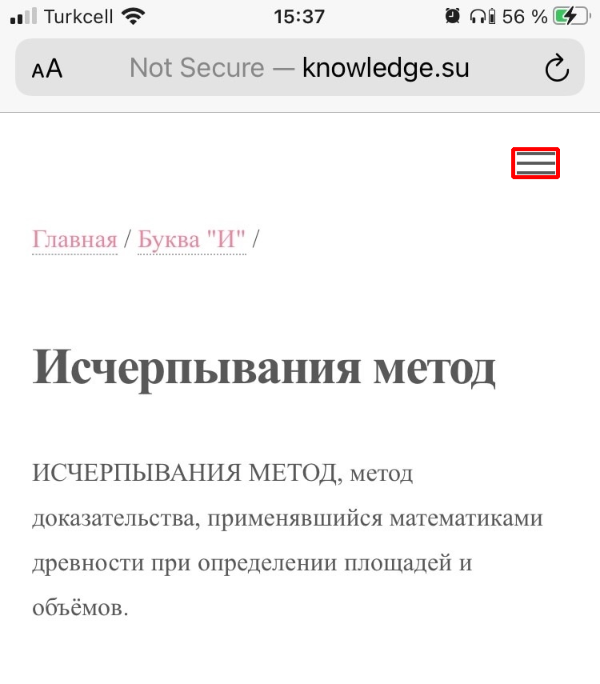

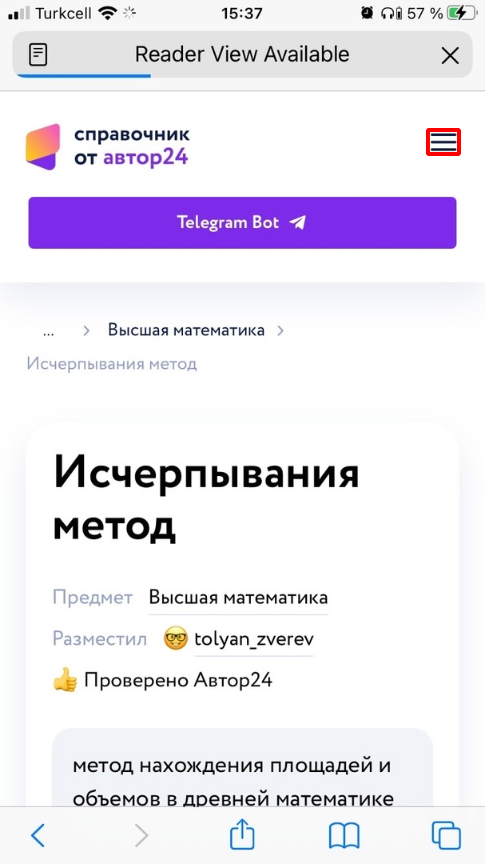

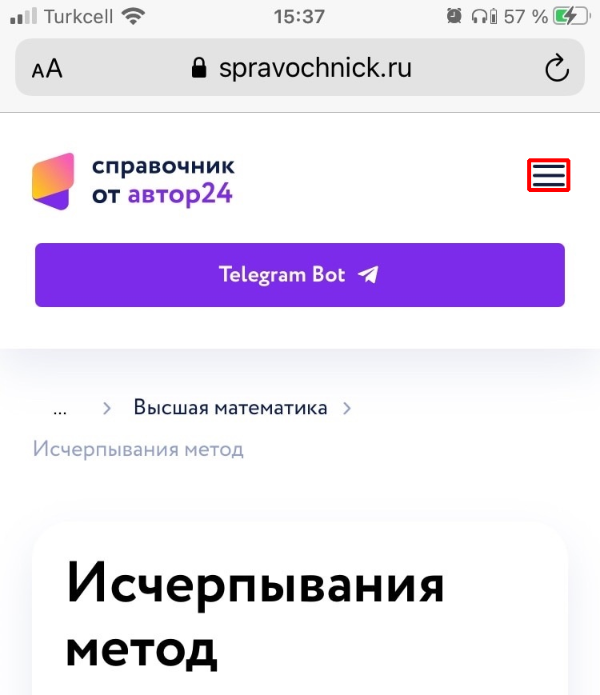

In [19]:
for i in range(len(df_val)):
  draw_predict(i)

In [20]:
weights_dir = '/content/gdrive/MyDrive/Weights_ML/burger_weights_2.pth'

In [21]:
torch.save(model.state_dict(), weights_dir)